In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
cash = 120000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-09-01_17-23_20180601_20191231.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df['contract'] = df['contract'].apply(lambda x: x[:2])

In [4]:
df[df['reason']=='CLOSE'].realizedPNL.count()/df.realizedPNL.count()*2

0.0565410199556541

In [5]:
#df = df[(df['contract'] == 'NQ') | (df['contract'] == 'ES') | (df['contract'] == 'YM')]

In [6]:
#df = df.loc['20190101':'20190701']

In [7]:
c = set(df['contract'])
allocs = pd.Series([1/len(c)]*len(c) +[1], index=list(c) + ['total'])
#allocs = pd.Series([1/3, 2/3, 1], index=['ES','NQ', 'total'])

In [8]:
allocs

ES       0.25
GC       0.25
NQ       0.25
YM       0.25
total    1.00
dtype: float64

In [9]:
df.groupby('contract').realizedPNL.sum()

contract
ES    19492.20
GC    10500.68
NQ    42312.00
YM    34954.80
Name: realizedPNL, dtype: float64

In [10]:
df.realizedPNL.sum()

107259.68000000001

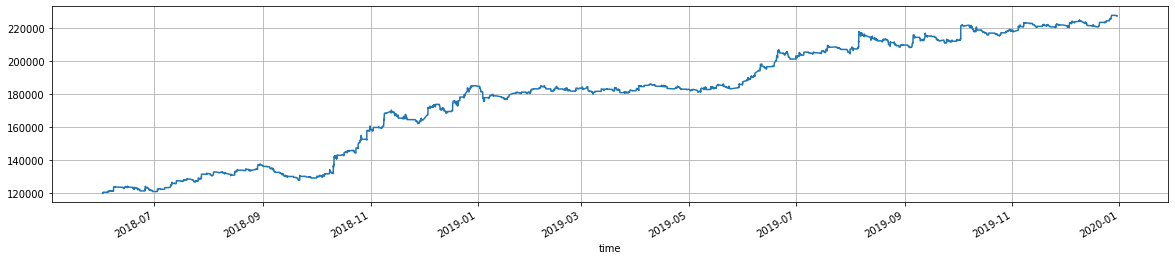

In [11]:
df.cash.plot(figsize=(20,4), grid=True);

In [12]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [13]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES     468
 GC     947
 NQ    1681
 YM     512
 Name: action, dtype: int64,
 3608)

In [14]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    1.135922
 GC    2.298544
 NQ    4.080097
 YM    1.242718
 Name: action, dtype: float64,
 8.757281553398059)

In [15]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES     982.80
GC    2291.74
NQ    3530.10
YM    1075.20
Name: commission, dtype: float64

In [16]:
df.commission.sum()

7879.840000000002

In [17]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
GC,0.40,22.20,449.63,-264.77,1.70,20.99,473.0
NQ,0.42,50.37,462.39,-242.49,1.91,53.56,840.0
ES,0.43,83.30,913.25,-546.96,1.67,80.93,234.0
YM,0.45,136.54,749.31,-355.40,2.11,141.72,256.0
total,0.42,59.49,562.95,-302.39,1.86,61.05,1803.0


In [18]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [19]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

contract,ES,GC,NQ,YM,total
contract,,,,,
ES,1.000000,0.019292,0.157918,0.549623,0.740936
GC,0.019292,1.000000,0.024055,0.049331,0.373980
NQ,0.157918,0.024055,1.000000,0.186250,0.587367
YM,0.549623,0.049331,0.186250,1.000000,0.732180
total,0.740936,0.373980,0.587367,0.732180,1.000000


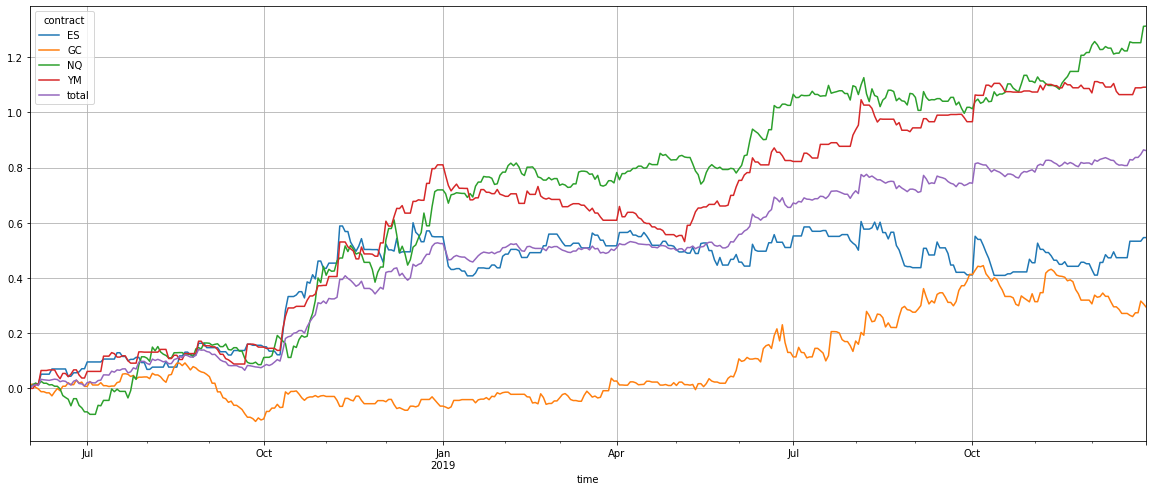

In [20]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

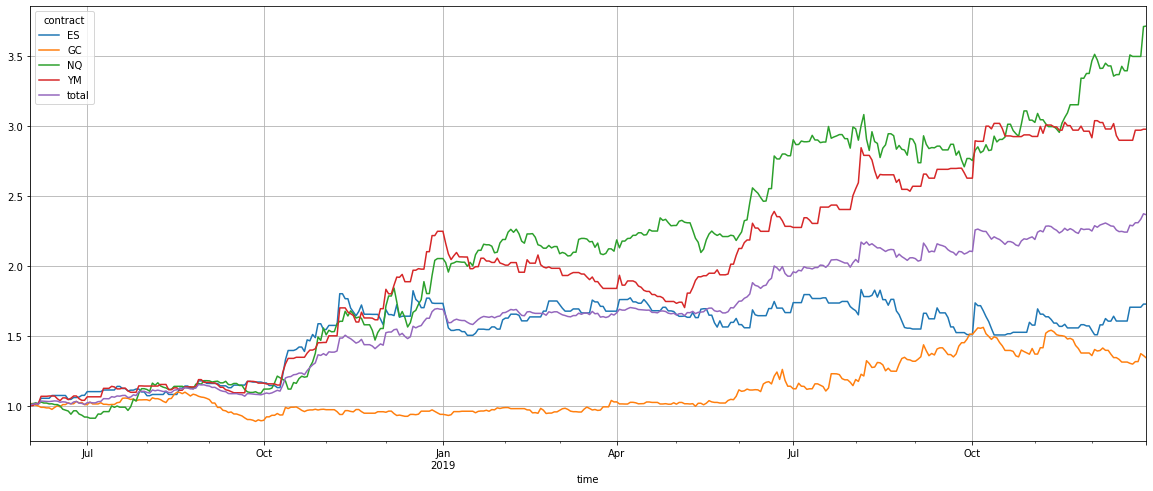

In [21]:
returns = daily.copy()
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [22]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(daily[col])
stats

,ES,GC,NQ,YM,total
Annual return,0.396795,0.197084,1.232127,0.949448,0.693631
Cumulative returns,0.726953,0.341924,2.716444,1.978397,1.366467
Annual volatility,0.361925,0.263768,0.345035,0.302525,0.198582
Sharpe ratio,1.098055,0.811665,2.500244,2.355745,2.753085
Calmar ratio,2.236038,1.031539,8.149705,3.907886,9.559974
Stability,0.497766,0.643281,0.928858,0.907547,0.941789
Max drawdown,-0.177455,-0.191059,-0.151187,-0.242957,-0.072556
Omega ratio,1.315704,1.177050,1.629231,1.826413,1.754001
Sortino ratio,2.259408,1.468168,4.768891,5.539172,6.249811
Skew,2.459321,1.494481,0.947878,2.388647,2.191810


In [23]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

contract,ES,GC,NQ,YM,total
time,,,,,
2018-06-30,7.38,0.72,-8.16,3.83,0.88
2018-07-31,2.25,3.48,22.09,9.82,9.32
2018-08-31,5.56,0.93,5.12,2.33,3.63
2018-09-30,0.86,-15.23,-7.55,-0.46,-5.71
2018-10-31,32.16,9.26,42.75,25.04,27.34
2018-11-30,2.23,-1.83,-0.23,16.64,4.43
2018-12-31,9.66,-1.97,32.26,32.71,17.94
2019-01-31,-6.81,4.99,6.65,-10.40,-1.51
2019-02-28,8.37,-2.96,-2.30,-1.55,0.43


In [24]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

contract
ES        73.0
GC        34.0
NQ       272.0
YM       198.0
total    137.0
dtype: float64

In [25]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2019-10-02 20:49:00,ES,BUY,2893.50,4508.3
2018-11-08 13:33:30,ES,SELL,2806.50,4320.8
2018-11-08 20:40:30,YM,SELL,26089.00,4000.8
2018-10-11 04:24:00,ES,BUY,2767.00,3395.8
2018-12-17 17:03:00,ES,BUY,2597.00,3333.3
...,...,...,...,...
2019-08-06 20:15:00,ES,BUY,2873.25,-1291.7
2018-12-10 13:56:30,ES,BUY,2638.75,-1329.2
2018-12-26 11:04:00,ES,BUY,2360.75,-1454.2


In [26]:
daily.sort_values('total', ascending=False)

contract,ES,GC,NQ,YM,total
time,,,,,
2019-10-02,0.150277,0.015688,0.026633,0.101693,0.073573
2019-08-05,0.109720,0.043839,0.035793,0.096387,0.071435
2018-11-08,0.144027,-0.021323,0.010527,0.133360,0.066648
2018-12-03,0.067777,-0.003989,0.103553,0.081860,0.062300
2019-09-05,0.072777,0.063344,0.070387,0.033887,0.060099
...,...,...,...,...,...
2019-08-22,-0.046947,-0.000495,-0.032920,-0.020447,-0.025202
2018-11-21,-0.038473,-0.011828,-0.028447,-0.024640,-0.025847
2019-01-02,-0.050973,-0.003495,-0.013920,-0.037973,-0.026590
